# Afternoon: Introduction to Spatial Analysis

Now that we've learned the basics of time series autocorrelation, we're ready to extend the concept to spatial dimensions. We'll see that spatial dimensions are a direct generalization of temporal dimension, and the concept of $lag$ carries over almost exactly. 

First we import the required packages. Again we also have to load the required R packages using `importr`.

In [1]:
#-- Import Required Python Packages
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import scipy.spatial
import scipy.linalg
from rpy2.robjects import pandas2ri
pandas2ri.activate()

#-- Import R packages in Python
r = robjects.r
nlme = importr('nlme')
gstat = importr('gstat')
sp = importr('sp')

If you don't already have the `gstat` package for R, you need to install it by running the following cell, which uses the `utils` package to install new packages. Uncomment the commands first.

In [2]:
# utils = importr("utils")
# utils.install_packages('gstat')

Then re-run the import cell.

## Simulate spatially correlated data
To get a sense how autocorrelation creates spatial patterns, let's try simulating data with different properties. Analogous to time series, we'll use a covariance matrix to describe the autocorrelation among variables within a statistical model. And remember again, we treat each observation as arising as a realization from a probability distribution. So when we talk about *correlations in the data* we are really taking about the correlation among these random variables that we describe statistically. In time series we computed correlations as a function of *lag*, but now we will compute correlations as a function of spatial distance.

There is an analagous autoregressive model for spatial data; however, it's a little more complicated to numerically optimize so we will use the common *exponential autocorrelation function* which closely approximates the autoregressive model, giving rise to very similar behaviour where *values closer to one another are more typically similar than values further away*. The approximation is $\alpha^{\tau} \approx e^{-r\tau}$, where $r$ is referred to as the *exponential decay parameter*. The exponential spatial covariance matrix takes the form

$$ \mathbf{\Sigma}_{exp} = \sigma^2 \begin{bmatrix}
   	  	    1 & e^{-rd_{1,2}} &          e^{-rd_{1,3}} &  \dots  & e^{-rd_{1,n}} \\
e^{-rd_{2,1}} &             1 &          e^{-rd_{2,3}} &  \ddots & e^{-rd_{2,n}} \\ 
e^{-rd_{3,1}} & e^{-rd_{3,2}} &                      1 & \ddots  & \vdots \\
       \vdots &        \ddots &                 \ddots &  \ddots & e^{-rd_{n-1,n}} \\
e^{-rd_{n,1}} & e^{-rd_{n,2}} & \dots & e^{rd_{n,n-1}} &       1 \end{bmatrix}  $$

Below we're going to simulate some data with exponential spatial correlation to get a sense of how this model generates spatial patterns. We'll consider a simulated 30x30 grid of observations. The key function below is the ``dist()`` command which computes the pairwise distances for all synthetic points. The $\mathbf{C}$ matrix defines the correlation matrix and $\mathbf{S}$ the resulting covariance matrix. Matrix $\mathbf{G}$ is the reflection of the covariance which is known as the *variogram*. We'll generally use the variogram for spatial analysis because it turns out to be a bit more convienient in a variety of settings.

In [3]:
# two column matrix with all pair-wise coordinates
M = np.array(np.meshgrid(range(1,31), range(1,31))).reshape(2, 30**2).T 
n = len(M)                                              # number of pairs
D_upper_triangle = scipy.spatial.distance.pdist(M)      # Upper triangle distance matrix
D = scipy.spatial.distance.squareform(D_upper_triangle) # convert to square form distance matrix
r0 = 0.1                                                # decorrelation parameter
s = 10                                                  # variance
C = np.exp(-r0*D)                                       # Correlation matrix
S = s**2*C                                              # construct covariance matrix based on distance
G = s**2*(1 - np.exp(-r0*D))                            # Analogous variogram matrix

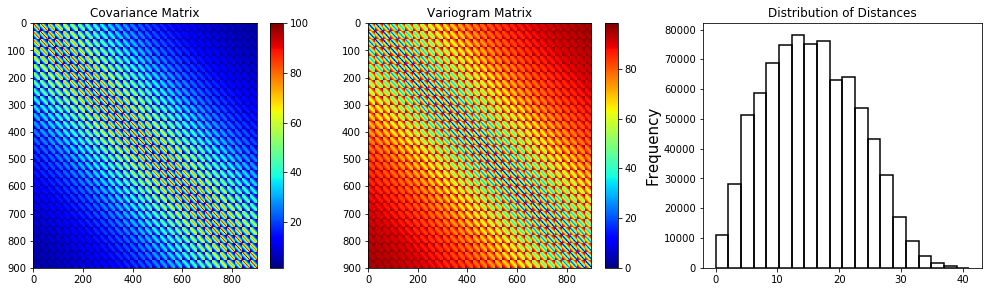

In [4]:
fig, ax = plt.subplots(1,3,figsize=(17,4.5))        # Set up figure and subplots
dist_fig = ax[0].imshow(S,cmap='jet',aspect='auto') # visualize the covariance matrix
fig.colorbar(dist_fig,ax=ax[0])                     # Add colorbar
ax[0].set_title('Covariance Matrix')                # Add title
corr_fig = ax[1].imshow(G,cmap='jet',aspect='auto') # visualize the variogram matrix
fig.colorbar(corr_fig,ax=ax[1])                     # Add colorbar
ax[1].set_title('Variogram Matrix')                 # Add title
ax[2].hist(D.flatten(),20,edgecolor='k',facecolor='none',linewidth=1.5) # make a histogram of the pair-wise distances
ax[2].set_ylabel('Frequency',fontsize=15)           # add y-label
ax[2].set_title('Distribution of Distances')        # add title
plt.show()

The two plots on the left and in the middle visualize the covariance matrix and variogram matrix, respectively. The plot on the right is a frequency histogram of all the pairwise distances. Notice there are the most pairs are of intermediate distance, with fewer points at short and long distances.

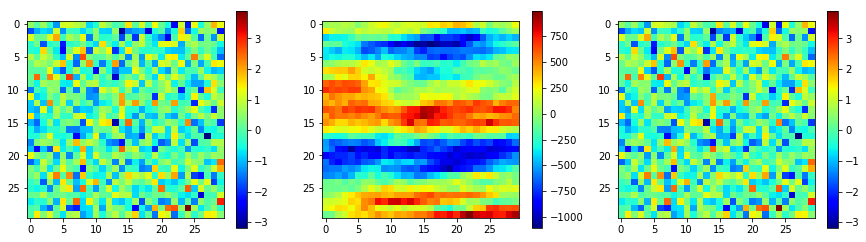

In [5]:
L = scipy.linalg.cho_factor(S,lower=True)               # Cholesky factorization of the covariance matrix
Li = np.linalg.inv(L[0])                                # Inverse of the triangular matrix for back-transform
x0 = np.random.normal(size=(1,n)) # random 1xn matrix drawn from Gaussian distribution
x = np.dot(x0,L[0])     #transform the random data by the factored covariance matrix to generate spatial correlation
x00 = np.dot(x,Li)      #transform back to random data by multiplying by the inverse of the factored covariance matrix
#-- plot
fig, ax = plt.subplots(1,3,figsize=(15,4))     # Set up figure and subplots
x0_fig = ax[0].imshow(x0.reshape(30,30),cmap='jet')  # Show original random matrix
fig.colorbar(x0_fig,ax=ax[0])                  # Add colorbar
x_fig = ax[1].imshow(x.reshape(30,30),cmap='jet')    # Show transformed random data with spatial correlation
fig.colorbar(x_fig,ax=ax[1])                   # Add colorbar
x00_fig = ax[2].imshow(x00.reshape(30,30),cmap='jet')# Show correlated data transformed back to random data
fig.colorbar(x00_fig,ax=ax[2])                 # Add colorbar
plt.show()

To see what's going on, consider the independent vector $\mathbf{x}_0$ with each element having variance $\sigma^2$. Recall the covariance matrix for this vector is $\mathbf{\Sigma} = \sigma^2 \mathbf{I}$. The correlated vector, on the other hand, $\mathbf{x} = \mathbf{Lx}_0$ has covariance $\mathbf{\Sigma} = S$. To see this, observe

$$ \mathrm{E}(\mathbf{xx'}) = \mathrm{E}((\mathbf{Lx}_0)(\mathbf{Lx}_0)') = \mathrm{E}(\mathbf{Lx}_0\mathbf{x}_0'\mathbf{L}') = \mathbf{L}\mathrm{E}(\mathbf{x}_0\mathbf{x}_0')\mathbf{L}'$$

Now we know from our assumptions that $\mathrm{E}(\mathbf{x}_0\mathbf{x}_0') = \mathbf{I}$ 

$$ L\mathrm{E}(\mathbf{x}_0\mathbf{x}_0')\mathbf{L}' = \mathbf{L}\sigma^2\mathbf{IL}' = \sigma^2\mathbf{LL}' = \mathbf{S} $$

## Spatial Interpolation
The term *interpolation* refers to the statistical process of 'filling in' values for unobserved locations. It is a very common statistical procedure (https://en.wikipedia.org/wiki/Multivariate_interpolation). There are many models to perform this task, but a common model with good statistical properties is known as Krigeing (https://en.wikipedia.org/wiki/Kriging). For some silly historical reason, people have altered the spelling of the term to kriging. But it is named after Krige, so I think the only spelling that makes any sense is Krigeing.  

First we will plot the data

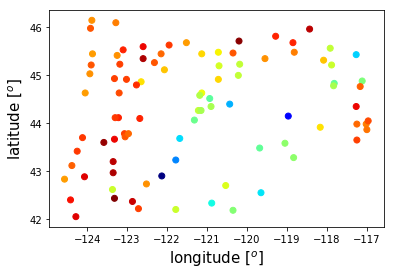

In [6]:
d = pd.read_csv('../Data/oregon_temp_precip.csv')            # Read Oregon data from repository
plt.scatter(d['lon'],d['lat'],c=d['temp_annual'],cmap='jet') # scatter plot, colors based on annual temp
plt.ylabel(r'latitude [$^o$]',fontsize=15)   # y label
plt.xlabel(r'longitude [$^o$]',fontsize=15)  # x label
plt.show()

We will use properties of the variogram (i.e. reflected variance) to predict values at unobserved locations. The general variogram can be written

$$ \gamma(y_i,y_j) = \gamma(d=d(y_i,y_j)) $$

where the variance between two spatial points (sometimes called *semivariance*) is a function of distance separating them. Our exponential variogram is

$$ \gamma(y_i-y_j) = \gamma(d) = \gamma_0 \left( 1-e^{-rd} \right)  $$

where the distance is defined as as the length of the vector separating $y_i$ and $y_j$. In this workshop we will be using simple Euclidean distance, $ d_E = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2} $, and will also use a package that computes distances according to from a geodesic projection of latitude and longitude onto the surface of the earth. 

Interpolation is a bit trickier than it seems. Krigeing, or so-called *optimal interpolation* is statistically derived by finding the linear predictor that a theoretical variance. We write the linear interpolation model

$$ y_0 = \sum_{i,j} w_{i,j} y_{i,j}    $$

Given the function $\gamma(d)$, where $d$ is the distance between we can define Krigeing equations. 

$$ \begin{bmatrix}
	  \gamma(y_1,y_1) & \gamma(y_1,y_2) &  \dots & \gamma(y_1,y_n) & 1 \\
   	  \gamma(y_2,y_1) & \gamma(y_2,y_2) &  \dots & \gamma(y_2,y_n) & 1 \\
   	           \vdots &          \vdots & \ddots &         \vdots  & 1 \\ 
      \gamma(y_n,y_1) & \gamma(y_n,y_2) &  \dots & \gamma(y_n,y_n) & 1 \\
                    1 &               1 &  \dots &               1 & 0  \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_n \\ 1 \end{bmatrix} 
= \begin{bmatrix} \gamma(y_1,y_0) \\ \gamma(y_2,y_0) \\ \vdots \\ \gamma(y_n,y_0) \\ 1 \end{bmatrix} $$

This system can be written in the following way, as a block matrix

$$ \left[
\begin{array}{c|c}
\mathbf{\Gamma} & \mathbf{1} \\ \hline \mathbf{1}^T & 0 \end{array} \right] \left[ \begin{array}{c}  \mathbf{w} \\ \hline \bar{y} \end{array} \right] = \left[ \begin{array}{c} \mathbf{\gamma_0} \\ \hline 1 \end{array} \right] $$

from which the we obtain the least squares estimates of the weights. It can be shown via the *Gauss-Markov theorem* (https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) that these values are the best estimates in terms of being unbiased and having the minimum variance of all possible estimators. This is often referred to in statistics with the acronym BLUE: *best linear unbiased estimator*. The least squares estimates of the weights, given $\gamma(d)$ is

$$ \mathbf{\hat{w}} = \mathbf{\Gamma^{-1}} \left[ \mathbf{\Gamma_0} - \bar{y} \mathbf{1} \right] $$ 

Given the estimated weights, we compute the prediction $y_0 = \sum_{i,j} w_{i,j} y_{i,j}$. The variance of the prediction is given by the expression. Naturally, the prediction variance increases with distance away from the observation via the variogram 

$$ \mathrm{Var}(y*) = \sigma^2 - \mathbf{w^T}\mathbf{\Gamma_0}. $$

Now all that is well and good. But the above assumes we know $\gamma(d)$. In practice this is not the case and we must estimate this via optimization. Turns out this is a bit of a numerical maneuver so we use software. One can estimate the variogram is various ways, but a common and intuitive approach is to fit functional forms to the empirical variogram. This is exactly analogous to the way we fit functional forms to the autocorrelation function. 

Below we use the ``gstat`` package to compute the empirical variogram. The package is saving us a lot of work here. It is binning the observations according to distance, computing the variance

$$ \hat{\gamma}(d) = \frac{1}{2N_d} \sum_{i,j} (y_i - y_j)^2$$

Over top we plot $N_d$ to remind you that there are an unequal number of observations

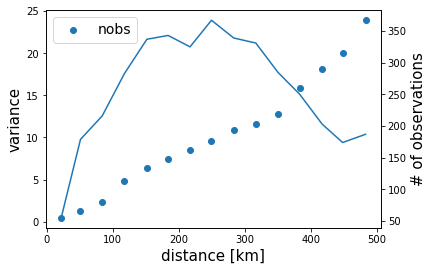

In [7]:
robjects.globalenv["lat"] = robjects.FloatVector(d['lat'])  # Add lat to R envrionment
robjects.globalenv["lon"] = robjects.FloatVector(d['lon'])  # Add lon to R envrionment
dsp = pandas2ri.py2ri(d)                                    # Convert d to R DataFrame
proj4string = robjects.r['proj4string']                     # get proj4string function
SpatialPoints = robjects.r['SpatialPoints']                 # get SpatialPoints function        
maptools_set = getattr(sp, 'coordinates<-')      # Get 'coordinates<-' command from sp
dsp = maptools_set(dsp,r.formula(' ~ lon + lat'))# Define coordinates; changes dsp to class spatial data frame
key =  sp.CRS("+proj=longlat +datum=WGS84")      # get projection key
dsp = SpatialPoints(dsp, proj4string = key)      # project latitude/longitude according to equal area

robjects.globalenv["temp_jan"] = robjects.FloatVector(d['temp_jan'])
d_evg = gstat.variogram(r.formula("temp_jan ~ 1"), dsp, cutoff=500)                  #estimate empirical variogram
fig, ax1 = plt.subplots()  # set up figure and axes
ax1.scatter(np.array(d_evg.rx2('dist')), np.array(d_evg.rx2('gamma')),label='nobs')  #plot the empirical variogram
ax2 = ax1.twinx() # make y axis on the right side
#--  plot the number of observations used to compute empirical variances
ax2.plot(np.array(d_evg.rx2('dist')),np.array(d_evg.rx2('np')))  

ax1.set_xlabel('distance [km]',fontsize=15)
ax1.set_ylabel('variance',fontsize=15)
ax2.set_ylabel('# of observations',fontsize=15)
ax1.legend(loc=2,fontsize=14)
plt.show()

Note about using maptools_set: In R, `coordinates(dsp)=~lon+lat` is the same as `dsp <- "coordinates<-"(dsp, formula("~lon+lat"))`. But python doesn't have this sort of embedded assignment, so we define the `"coordinates<-"` command and pass the object and the formula as arguments in one step.

Now our job is to fit a functional form to this empirical scatterplot. In R package ``gstat``, the function ``fit_variogram`` will do this for us, with some fancy backend magic regarding how to treat the unequal number of observations. The function takes the initial values for the variogram parameters as inputs, which tells the function which parameteres to include in the model. Additional arguements can be used to tell the package which parameters to keep fixed. We eyeball and fix the range as it appears to considerably help convergence for this particular dataset. Then we plot the empirical and optimized variogram simultaneously. Note in `Python` we have to first evaluate the $(x,y)$ coordinates of the optimized variogram from the functional form using `gstat.variogramLine()`.

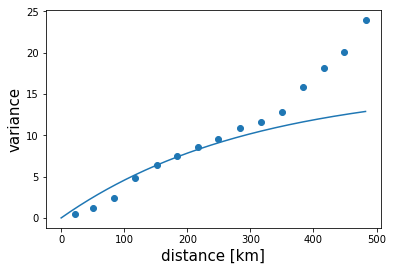

In [8]:
d_vg = gstat.fit_variogram(d_evg, model=gstat.vgm(psill=20,    #initial sill value for optimizer
                           model="Exp",                        #functional form
                           range=300,                          #initial range value
                           nugget=0.2*np.mean(d['temp_jan'])), #initial nuggest value
                           fit_ranges=False)                   #tell the package not to optimize range (helps with convergence)

vg_points = gstat.variogramLine(d_vg,np.max(np.array(d_evg.rx2('dist')))) # fill out values from variogram model
plt.scatter(np.array(d_evg.rx2('dist')), np.array(d_evg.rx2('gamma')))    #plot the empirical variogram
plt.plot(np.array(vg_points.rx2('dist')),np.array(vg_points.rx2('gamma')))# plot optimized variogram  
plt.xlabel('distance [km]',fontsize=15)
plt.ylabel('variance',fontsize=15)
plt.show()

As pointed out above, the goal of Krigeing is often to interpolate values at unobserved locations. Given the optimized variogram, we can now construct our necessary function $\gamma(d)$ for the observations and new point to predict from. Similarly, we can construct the variance of those predictions.  

[using ordinary kriging]


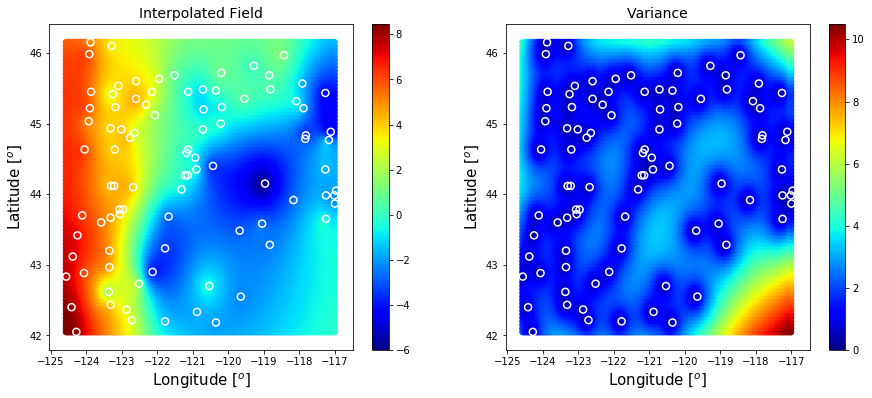

In [9]:
min_lat, max_lat = np.min(d['lat']), np.max(d['lat']) #obserbed latitude range
min_lon, max_lon = np.min(d['lon']), np.max(d['lon']) #observed longitude range

res = 0.05                                            #resolution of input lat/lon grid [degrees]
lat0 = np.arange(min_lat,max_lat,res)                 #input latitudes
lon0 = np.arange(min_lon,max_lon,res)                 #input longitudes
expand_grid = robjects.r['expand.grid']               #get expand.grid function from R
grd = expand_grid(lon=lon0,lat=lat0)                  #input grid  

maptools_set = getattr(sp, 'coordinates<-')      # Get 'coordinates<-' command from sp
grd = maptools_set(grd,r.formula(' ~ lon + lat'))# Define coordinates; changes dsp to class spatial data frame
key =  sp.CRS("+proj=longlat +datum=WGS84")      # get projection key
grd = SpatialPoints(grd, proj4string = key)      # project latitude/longitude according to equal area
gridded_func = getattr(sp, 'gridded<-')          # Get 'Gridded<-' command from sp
grd = gridded_func(grd,True)

#-- krigeing prediction; temp_jan ~ 1 specifies the mean, locations defines 
#-- observation points, newdata represents prediction points
d_k = gstat.krige(formula=r.formula("temp_jan ~ 1"), locations=dsp, newdata=grd, model=d_vg)
dk_data = np.array(d_k.slots['data']).T         # Extracted interpolated data and take transpose to match coord shape
dk_coords = np.array(d_k.slots['coords'])       # Extract coordinates
fig, ax = plt.subplots(1,2,figsize=(15,6))      # Set up figure and subplots
#-- plot interpolated field
int_fig = ax[0].scatter(dk_coords[:,0],dk_coords[:,1],c=dk_data[:,0],cmap='jet')
fig.colorbar(int_fig,ax=ax[0])                    # Add colorbar
ax[0].scatter(d['lon'],d['lat'],s=50,facecolors='none', edgecolors='white',linewidth=1.5) #add original data points
ax[0].set_xlabel(r'Longitude [$^o$]',fontsize=15) # Add x axis label
ax[0].set_ylabel(r'Latitude [$^o$]',fontsize=15)  # Add y axis label
ax[0].set_title('Interpolated Field',fontsize=14)
#-- plot variance
var_fig = ax[1].scatter(dk_coords[:,0],dk_coords[:,1],c=dk_data[:,1],cmap='jet')
fig.colorbar(var_fig,ax=ax[1])                    # Add colorbar
ax[1].scatter(d['lon'],d['lat'],s=50,facecolors='none', edgecolors='white',linewidth=1.5) #add original data points
ax[1].set_xlabel(r'Longitude [$^o$]',fontsize=15) # Add x axis label
ax[1].set_ylabel(r'Latitude [$^o$]',fontsize=15)  # Add y axis label
ax[1].set_title('Variance',fontsize=14)
plt.show()

## Spatial regression
Again following from the time series regression, we can investigate the relation among two variables while accounting for spatial autocorrelation. The linear regression we will fit is written as 

$$ y_i = \beta_0 + \beta_1 x1_i + \beta_2 x2_i + ,..., + \beta_n xn_i + e_i  $$

with a number of input varibles $n$, where $e_i$ is a Gaussian variable with spatial covariance $\mathbf{\Sigma}$. 

We take a look at the first few rows of the data to remind us of the variables

In [10]:
d.head(n=3)     #display the top three rows of the dataset

,station,lat,lon,elevation,temp_jan,temp_jul,temp_annual,precip_jan,precip_jul,precip_ann,county
0,ANT,44.917,-120.717,846,0.0,20.2,9.6,41,9,322,ANTELOPE 1 N USA-OR
1,ARL,45.717,-120.200,96,0.9,24.6,12.5,40,6,228,ARLINGTON USA-OR
2,ASH,42.217,-122.717,543,3.1,20.8,11.1,70,7,480,ASHLAND 1 N USA-OR


Below we fit the regression model with a single covariate and an exponential covariance matrix

In [11]:
robjects.globalenv["precip_ann"] = robjects.FloatVector(d['precip_ann'])  # Add precip to R envrionment 
robjects.globalenv["temp_annual"] = robjects.FloatVector(d['temp_annual'])# Add precip to R envrionment 
robjects.globalenv["lat"] = robjects.FloatVector(d['lat'])                # Add lat to R envrionment
robjects.globalenv["lon"] = robjects.FloatVector(d['lon'])                # Add lon to R envrionment
#-- fit linear regression model while account for spatial autocorrelation 
fit = nlme.gls(r.formula("precip_ann ~ temp_annual"),
               correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')  
print r.summary(fit)    # print a summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual 
  Data: NULL 
       AIC      BIC    logLik
  1297.666 1307.753 -644.8329

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
   range 
6.072546 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1825.4297  711.1956  2.566706  0.0119
temp_annual  -71.6271   20.8419 -3.436694  0.0009

 Correlation: 
            (Intr)
temp_annual -0.303

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2982015 -0.9274755 -0.6598595  0.3166358  1.5576293 

Residual standard error: 917.6314 
Degrees of freedom: 92 total; 90 residual



In [12]:
robjects.globalenv["elevation"] = robjects.FloatVector(d['elevation'])  # Add eleavtion to R envrionment
#-- fit regression model to two parameters
fit2 = nlme.gls(r.formula("precip_ann ~ temp_annual + elevation"), 
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')   
print r.summary(fit2)     # summary of the fitted model object

Generalized least squares fit by maximum likelihood
  Model: precip_ann ~ temp_annual + elevation 
  Data: NULL 
       AIC      BIC    logLik
  1299.665 1312.273 -644.8323

Correlation Structure: Exponential spatial correlation
 Formula: ~lat + lon 
 Parameter estimate(s):
  range 
6.00687 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 1839.7755  834.5722  2.204453  0.0301
temp_annual  -72.8775   40.1626 -1.814559  0.0730
elevation     -0.0087    0.2362 -0.036931  0.9706

 Correlation: 
            (Intr) tmp_nn
temp_annual -0.584       
elevation   -0.526  0.853

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.3011053 -0.9242965 -0.6596994  0.3196872  1.5646255 

Residual standard error: 912.847 
Degrees of freedom: 92 total; 89 residual



Just like we fitted a variogram to observed data, we can also fit a variogram model to model predictions. Below we take the predictions from the linear regression model and estimate their predicted empirical variogram. 

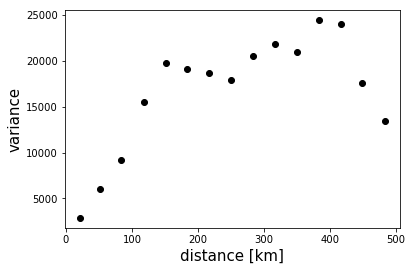

In [13]:
robjects.globalenv["pred"] = robjects.FloatVector(r.predict(fit2))  # Add prediction to R envrionment 
pred_evg = gstat.variogram(r.formula("pred ~ 1"), dsp, cutoff=500)  # variogram
#plot the empirical variogram
plt.plot(np.array(pred_evg.rx2('dist')), np.array(pred_evg.rx2('gamma')),'ko')  
plt.xlabel('distance [km]',fontsize=15)
plt.ylabel('variance',fontsize=15)
plt.show()

[using ordinary kriging]


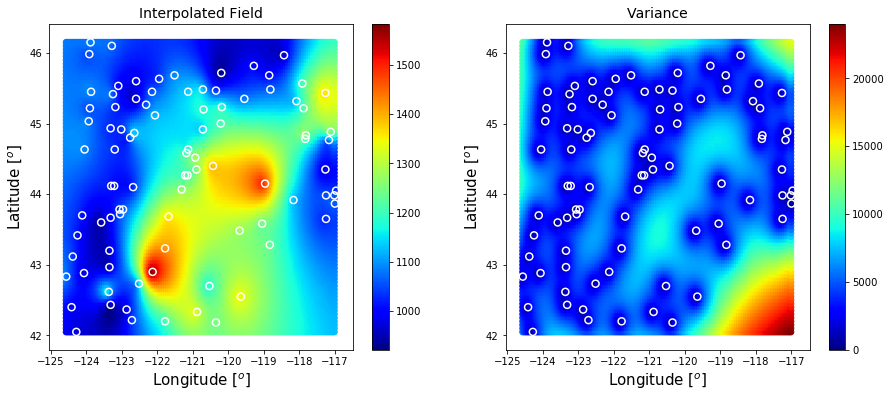

In [14]:
min_lat, max_lat = np.min(d['lat']), np.max(d['lat']) #obserbed latitude range
min_lon, max_lon = np.min(d['lon']), np.max(d['lon']) #observed longitude range

res = 0.05                                            #resolution of input lat/lon grid [degrees]
lat0 = np.arange(min_lat,max_lat,res)                 #input latitudes
lon0 = np.arange(min_lon,max_lon,res)                 #input longitudes
expand_grid = robjects.r['expand.grid']               #get expand.grid function from R
grd = expand_grid(lon=lon0,lat=lat0)                  #input grid  

maptools_set = getattr(sp, 'coordinates<-')      # Get 'coordinates<-' command from sp
grd = maptools_set(grd,r.formula(' ~ lon + lat'))# Define coordinates; changes dsp to class spatial data frame
key =  sp.CRS("+proj=longlat +datum=WGS84")      # get projection key
grd = SpatialPoints(grd, proj4string = key)      # project latitude/longitude according to equal area
gridded_func = getattr(sp, 'gridded<-')          # Get 'Gridded<-' command from sp
grd = gridded_func(grd,True)

pred_vg = gstat.fit_variogram(pred_evg, model=gstat.vgm(psill=20,model="Exp",range=200,
                                                   nugget=0.2*np.mean(d['temp_jan'])), fit_ranges=False)

#-- krigeing prediction; temp_jan ~ 1 specifies the mean, locations defines 
#-- observation points, newdata represents prediction points
d_k = gstat.krige(formula=r.formula("pred ~ 1"), locations=dsp, newdata=grd, model=pred_vg)
dk_data = np.array(d_k.slots['data']).T         # Extracted interpolated data and take transpose to match coord shape
dk_coords = np.array(d_k.slots['coords'])       # Extract coordinates
fig, ax = plt.subplots(1,2,figsize=(15,6))      # Set up figure and subplots
#-- plot interpolated field
int_fig = ax[0].scatter(dk_coords[:,0],dk_coords[:,1],c=dk_data[:,0],cmap='jet')
fig.colorbar(int_fig,ax=ax[0])                    # Add colorbar
ax[0].scatter(d['lon'],d['lat'],s=50,facecolors='none', edgecolors='white',linewidth=1.5) #add original data points
ax[0].set_xlabel(r'Longitude [$^o$]',fontsize=15) # Add x axis label
ax[0].set_ylabel(r'Latitude [$^o$]',fontsize=15)  # Add y axis label
ax[0].set_title('Interpolated Field',fontsize=14)
#-- plot variance
var_fig = ax[1].scatter(dk_coords[:,0],dk_coords[:,1],c=dk_data[:,1],cmap='jet')
fig.colorbar(var_fig,ax=ax[1])                    # Add colorbar
ax[1].scatter(d['lon'],d['lat'],s=50,facecolors='none', edgecolors='white',linewidth=1.5) #add original data points
ax[1].set_xlabel(r'Longitude [$^o$]',fontsize=15) # Add x axis label
ax[1].set_ylabel(r'Latitude [$^o$]',fontsize=15)  # Add y axis label
ax[1].set_title('Variance',fontsize=14)
plt.show()

## Alternative autocorrelation functions
So far we have considered two closely related autocorrelation functions, the *first order autoregressive* covariance for time series, and the *exponential* autocovariance for spatial data. There is actually many functional forms we could use. Again casting the autocorrelation function in terms of the variogram, we can take a look at the available variograms in ``gstat`` by issueing the command  ``show.vgms()``. Note the plot should appear in a separate window (If an empty window pops up, run the cell again).

In [15]:
p = gstat.show_vgms()  
print(p)

Below we optimize the parameters for two different functional forms and plot the results.

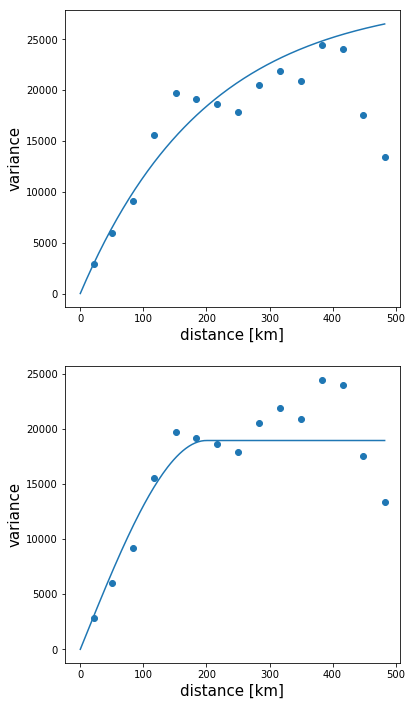

In [16]:
pred_vg1 = gstat.fit_variogram(pred_evg, model=gstat.vgm(psill=20,model="Exp",range=200,
                                                   nugget=0.2*np.mean(d['temp_jan'])), fit_ranges=False)
pred_vg2 = gstat.fit_variogram(pred_evg, model=gstat.vgm(psill=20,model="Sph",range=200,
                                                   nugget=0.2*np.mean(d['temp_jan'])), fit_ranges=False)
vg_points = {} # make a dictionary for the optimized variogram values for both models 
vg_points[0] = gstat.variogramLine(pred_vg1,
                                 np.max(np.array(pred_evg.rx2('dist')))) # fill out values from variogram model
vg_points[1] = gstat.variogramLine(pred_vg2,
                                 np.max(np.array(pred_evg.rx2('dist')))) # fill out values from variogram model
fig,ax = plt.subplots(2,1,figsize=(6,12))
for i in [0,1]: # loop over the subplots and plot both variograms
    ax[i].scatter(np.array(pred_evg.rx2('dist')), np.array(pred_evg.rx2('gamma')))     #plot empirical variogram
    ax[i].plot(np.array(vg_points[i].rx2('dist')),np.array(vg_points[i].rx2('gamma'))) # plot optimized variogram
    ax[i].set_xlabel('distance [km]',fontsize=15)    # set x label 
    ax[i].set_ylabel('variance',fontsize=15)         # set y label
plt.show()

As we learned in the time series section, we can also perform model selection with respect to spatial regression variables and also spatial variograms. We again use the Bayesian information criterion (BIC) as a simple metric to balance the quality of the fit and the number of parameters used to fit the model

$$ \mathrm{BIC} = -2\log p(\mathbf{y} | \hat{\mathbf{\theta}},M,\hat{\sigma}^2) + k\log n $$

where $\log p(\mathbf{y} | \hat{\mathbf{\theta}},M,\hat{\sigma}^2)$ is the log likelihood for the observations evaluated at the optimal parameters, conditional on the model $M$, $k$ is the number of free parameters used to fit the model, and $n$ is the number of data points in the fit. 

# Model Selection

In [17]:
#-- fit the regression with exponential covariance matrix
fit1 = nlme.gls(r.formula("precip_ann ~ temp_annual"),
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')
fit2 = nlme.gls(r.formula("precip_ann ~ elevation"),
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')
fit3 = nlme.gls(r.formula("precip_ann ~ temp_annual + elevation"),
                correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')
#-- display the Bayesian Information Criterion of the fits     
bic = r.BIC(fit1,fit2,fit3)
bic_dic = dict(zip(bic.names, map(list,list(bic)))) # convert to python dictionary
bic_dic['models'] = ['fit1','fit2','fit3']          # Add model info
bic_pd = pd.DataFrame(data=bic_dic,columns=np.concatenate([['models'],bic.names])) #make into Pandas DataFrame
bic_pd # Display BIC table

,models,df,BIC
0,fit1,4.0,1307.752934
1,fit2,4.0,1310.967816
2,fit3,5.0,1312.273443


In [18]:
#-- fit the regression with exponential covariance matrix
fit1spher = nlme.gls(r.formula("precip_ann ~ temp_annual"),
                     correlation=nlme.corSpher(form=r.formula("~lat+lon"),nugget=False),method='ML') 
fit1exp = nlme.gls(r.formula("precip_ann ~ temp_annual"),
                   correlation=nlme.corExp(form=r.formula("~lat+lon"),nugget=False),method='ML')

#-- display the Bayesian Information Criterion of the fits     
bic = r.BIC(fit1spher,fit1exp)
bic_dic = dict(zip(bic.names, map(list,list(bic)))) # convert to python dictionary
bic_dic['models'] = ['fit1spher','fit1exp']         # Add model info
bic_pd = pd.DataFrame(data=bic_dic,columns=np.concatenate([['models'],bic.names])) #make into Pandas DataFrame
bic_pd # Display BIC table

,models,df,BIC
0,fit1spher,4.0,1306.940203
1,fit1exp,4.0,1307.752934
